# Future sales predictor - Kaggle

In [1]:
import pandas as pd
import numpy as np

In [51]:
train = pd.read_csv('sales_train.csv')
train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_count
0,02.01.2013,0,59,22154,999.00,1
1,03.01.2013,0,25,2552,899.00,1
2,05.01.2013,0,25,2552,899.00,-1
3,06.01.2013,0,25,2554,1709.05,1
4,15.01.2013,0,25,2555,1099.00,1
5,10.01.2013,0,25,2564,349.00,1
6,02.01.2013,0,25,2565,549.00,1
7,04.01.2013,0,25,2572,239.00,1
8,11.01.2013,0,25,2572,299.00,1
9,03.01.2013,0,25,2573,299.00,3


In [3]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [4]:
train.shape

(2935849, 6)

In [5]:
items = pd.read_csv('items.csv')
del items['item_name']
items.head(10)

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40
5,5,40
6,6,40
7,7,40
8,8,40
9,9,40


In [6]:
test = pd.read_csv('test.csv')
test.head(10)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
5,5,5,5039
6,6,5,5041
7,7,5,5046
8,8,5,5319
9,9,5,5003


In [83]:
def clean_data(df):
    data = df
    target = []
    if 'date' in data:
        del data['date']
    if 'date_block_num' in data:
        del data['date_block_num']
    
    if 'item_count' in data:
        target = data['item_count']
        data =  data.drop(columns=['item_count'])
        
    if 'ID' in data:
        target = data['ID']
        prices = pd.DataFrame(train, columns=['item_price', 'item_id'])
        data =  data.drop(columns=['ID'])
        data = pd.merge(data, prices, on='item_id', how='inner')
    data = pd.merge(data, items, on='item_id', how='inner')
    return data, target

In [45]:
X, y = clean_data(train)

0          1
1          1
2         -1
3          1
4          1
          ..
1048570    1
1048571    1
1048572    1
1048573    1
1048574    1
Name: item_count, Length: 1048575, dtype: int64


In [46]:
X

,shop_id,item_id,item_price,item_category_id
0,59,22154,999.0,37
1,24,22154,999.0,37
2,27,22154,999.0,37
3,25,22154,999.0,37
4,25,22154,999.0,37
...,...,...,...,...
1048570,35,2797,1299.0,23
1048571,31,20866,1499.0,72
1048572,31,20203,349.0,40
1048573,41,7963,7990.0,15


In [47]:
y

0          1
1          1
2         -1
3          1
4          1
          ..
1048570    1
1048571    1
1048572    1
1048573    1
1048574    1
Name: item_count, Length: 1048575, dtype: int64

In [89]:
X_real_test, id_list = clean_data(test)

In [90]:
id_list

0              0
1              1
2              2
3              3
4              4
           ...  
214195    214195
214196    214196
214197    214197
214198    214198
214199    214199
Name: ID, Length: 214200, dtype: int64

In [88]:
X_real_test.shape

(11511066, 4)

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<AxesSubplot:title={'center':'Pearson correlation of features'}>

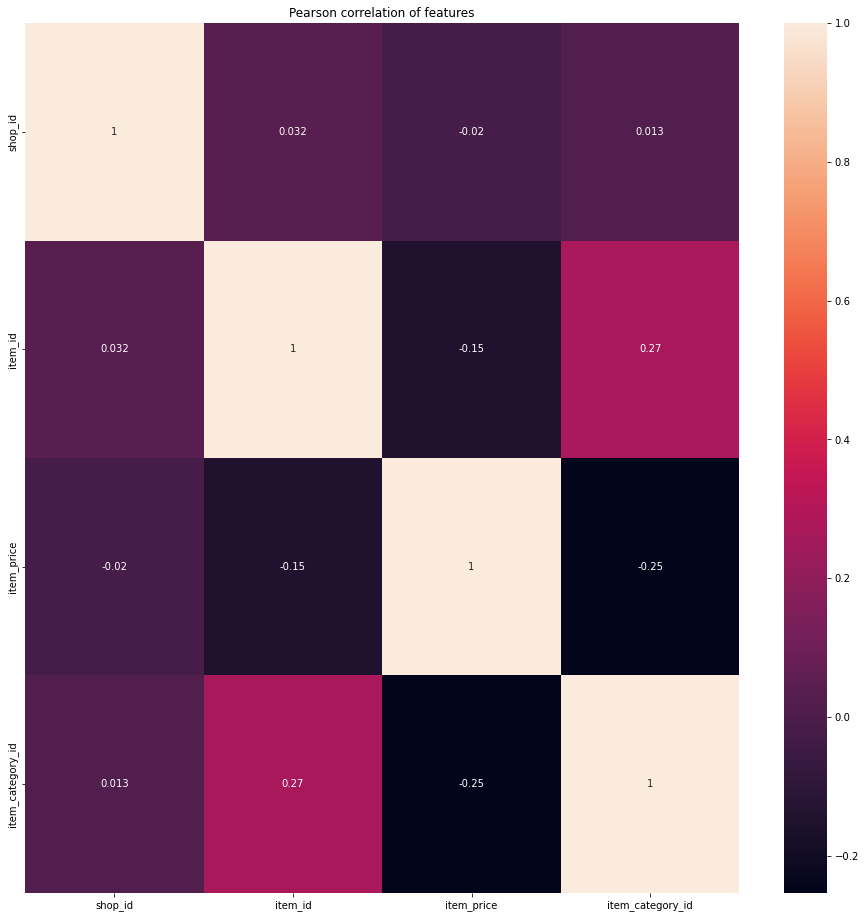

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(16,16))
plt.title('Pearson correlation of features')
sns.heatmap(X_train.astype(float).corr(), annot=True)

In [57]:
estimators = []
accuracies = {}

In [93]:
class RegressionModel(object):
    def __init__(self, name, reg, params=None):
        self.reg = reg(**params)
        self.name = name

    def train(self):
        self.reg.fit(X_train, y_train)
    
    def fit(self):
        return self.reg.fit(X_train, y_train)
    
    def fitEnsemble(self, X, y):
        return self.reg.fit(X, y)
    
    def feature_importances(self):
        return self.reg.fit(X_fake_test, y_fake_test).feature_importances_
    
    def predict(self, x):
        return self.reg.predict(x)
    
    def predict_test(self):
        test_ypred = self.reg.predict(X_real_test)
        output = pd.DataFrame({'ID': id_list,
                      "item_cnt_day": test_ypred})
        
        output.to_csv('Submission_'+ self.name +'.csv', index= False)
        return output

In [64]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def trainModel(model):
    estimators.append((model.name, model.reg))
    model.fit()
    scores = [0.0, 0.0, 0.0]
#     features = model.feature_importances()
    test_ypred = model.predict(X_test)
    scores[0] = r2_score(y_test, test_ypred)
    scores[1] = mean_absolute_error(y_test, test_ypred)
    scores[2] = np.sqrt(mean_squared_error(y_test, test_ypred))
    accuracies[model.name] = scores
    return scores, test_ypred

In [65]:
from sklearn.linear_model import LinearRegression
lr_params = {
    'n_jobs': -1,
    
}
lr_model = RegressionModel(name='Linear', reg=LinearRegression, params=lr_params)
lr_scores, lr_predtest = trainModel(lr_model)
lr_scores

[9.039788315090558e-05, 0.40427807493863394, 1.5488935837357705]

In [66]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest parameters
rfr_params = {
    'n_estimators': 400,
    'max_depth': 5,
    'min_samples_leaf': 3,
    'max_features' : 'sqrt',
}
rfr_model = RegressionModel(name='Random_Forest', reg=RandomForestRegressor, params=rfr_params)
rfr_scores, rfr_predtest = trainModel(rfr_model)
rfr_scores

[0.0038168461185557057, 0.40316671360832407, 1.5460046928674294]

In [68]:
from sklearn.ensemble import ExtraTreesRegressor

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':400,
    'max_depth': 5,
    'min_samples_leaf': 2,
}
etr_model = RegressionModel(name='Extra_Trees', reg=ExtraTreesRegressor, params=et_params)
etr_scores, etr_predtest = trainModel(etr_model)
etr_scores

[0.0007498257904855476, 0.40397036956281723, 1.5483827615047212]

In [70]:
from sklearn.ensemble import BaggingRegressor

# Bagging Regressor Parameters
br_params = {
    'n_jobs': -1,
    'n_estimators':400,
}
br_model = RegressionModel(name='Bagging', reg=BaggingRegressor, params=br_params)
br_scores, br_predtest = trainModel(br_model)
br_scores

[-0.06616747508652376, 0.38065860601342294, 1.5993883418738855]

In [94]:
import xgboost as xgb

xgb_params = {
#     'learning_rate': 0.025,
#     'n_estimators': 600,
#     'criterion': 'friedman_mse'
}
xgb_model = RegressionModel(name='X_Boost', reg=xgb.XGBRegressor, params=xgb_params)
xgb_scores, xgb_predtest = trainModel(xgb_model)
xgb_scores

[0.038076564860430095, 0.3898995912743238, 1.5191877996555965]

In [74]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_params = {
    'learning_rate': 0.1,
    'n_estimators': 600,
    'criterion': 'friedman_mse'
}
gbr_model = RegressionModel(name='Gradient_Boosting', reg=GradientBoostingRegressor, params=gbr_params)
gbr_scores, gbr_predtest = trainModel(gbr_model)
gbr_scores

[0.011292377355649919, 0.40119369119210274, 1.540193025662842]

In [78]:
def extract(index):
    return [item[index] for item in list(accuracies.values())]

In [95]:
model_accuracies=pd.DataFrame({'Models': accuracies.keys(),
                               'R2': extract(0),
                               'Mean Absolute Error': extract(1),
                                'Mean Squared Error': extract(2)})

In [96]:
model_accuracies.sort_values(by='Mean Squared Error',ascending=True,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,R2,Mean Absolute Error,Mean Squared Error
0,X_Boost,0.038077,0.389900,1.519188
1,Gradient_Boosting,0.011292,0.401194,1.540193
2,Random_Forest,0.003817,0.403167,1.546005
3,Extra_Trees,0.000750,0.403970,1.548383
4,Linear,0.000090,0.404278,1.548894
5,Bagging,-0.066167,0.380659,1.599388


In [97]:
gbr_model.predict_test()

ValueError: array length 209715 does not match index length 214200